# Autoencoder

In dit notebook maken en trainen we een autoencoder voor de `mnist` dataset.
We gebruiken deze vervolgens om nieuw afbeeldingen van handgeschreven letters te genereren.

De code in dit voorbeeld is gebaseerd op de code uit hoofdstuk 3 van *Generative Deep Learning* van David Forester, O'Reilly Media, 2019 en op hoofdstuk 8 van *Deep Learning with Python* door François Chollet, Manning, 2018.

### Wat zijn Autoencoders?

Autoencoders zijn een specifiek type neuraal netwerk dat wordt gebruikt voor ongecontroleerd leren. Ze zijn ontworpen om automatisch te leren hoe ze inputdata efficiënt kunnen coderen. Dit wordt bereikt door de inputdata te comprimeren in een latente ruimte en vervolgens de originele inputdata te reconstrueren vanuit deze gecomprimeerde representatie.

Een autoencoder bestaat uit twee delen: een encoder en een decoder. De encoder neemt de inputdata en comprimeert deze in de latente ruimte. De decoder neemt vervolgens de gecomprimeerde data en reconstrueert de originele input. Het doel van een autoencoder is om de decoder zo te trainen dat de output zo dicht mogelijk bij de originele input ligt.

Autoencoders kunnen worden gebruikt voor een verscheidenheid aan taken, waaronder dimensiereductie, anomaliedetectie en generatieve modellen.

De MNIST dataset is een grote database van handgeschreven cijfers die vaak wordt gebruikt in het veld van machine learning. Het bestaat uit 60.000 trainingsafbeeldingen en 10.000 testafbeeldingen. Elke afbeelding is een 28x28 pixel grayscale afbeelding van een handgeschreven cijfer tussen 0 en 9.

In de context van autoencoders, kan de MNIST dataset worden gebruikt om een autoencoder te trainen om handgeschreven cijfers te coderen en decoderen. De input voor de autoencoder zou de afbeeldingen van de cijfers zijn, en de output zou een reconstructie van deze afbeeldingen zijn. De latente ruimte zou een gecomprimeerde representatie van de afbeeldingen bevatten. Door te leren hoe deze afbeeldingen te coderen en decoderen, kan de autoencoder leren hoe de structuur van de data eruit ziet en hoe verschillende cijfers van elkaar verschillen.

In [1]:
import numpy as np

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
#from keras.optimizers import Adam
from keras.optimizers.legacy import Adam
from keras.losses import MeanSquaredError

from keras.datasets import mnist

In [2]:
#check the version of python
import sys
print(sys.version)

3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]


In [3]:
#check the version of keras
import keras
keras.__version__

'2.15.0'

In [4]:
#check the version of tensorflow
import tensorflow as tf
tf.__version__

'2.15.0'

### Verover de data

##### De pixel waardes worden door 255 gedeelt, waarom?
- De pixel waarden van een image is van 0 tot 255. Om het door 255 te delen, worden deze waarden tussen 0 tot 1. Dit noemen we normaliseren. Dit helpt het model om beter en sneller met de data om te gaan

##### Er vindt een reshape plaats, waarom?
- Reshape wordt gebruikt om de dimensies van de data te veranderen zodat het matcht met wat het model verwacht.


In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
    
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

Afbeeldingen zijn 28x28 pixels in zwart/wit (1 kanaal).

We projecteren iedere afbeelding naar 2 getallen.

In [6]:
input_dim = (28, 28, 1)
z_dim = 2

### Encoder

We maken eerst een `encoder`. We maken hiervoor gebruik van de functionele notatie van Keras. De `encoder` is in essentie een CNN dat een afbeelding terugbrengt tot twee getallen.

In [7]:
encoder_input = Input(input_dim, name = 'encoder_input')

x = Conv2D(filters = 32,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_1')(encoder_input)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           strides = (2,2),
           padding = 'same',
           name = 'encoder_conv_2')(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           strides = (2,2),
           padding = 'same',
           name = 'encoder_conv_3')(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_4')(x)
x = LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)

encoder_output = Dense(z_dim, name = 'encoder_output')(x)

encoder = Model(encoder_input, encoder_output)

In [8]:
# Model summary
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 encoder_conv_3 (Conv2D)     (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 64)          0     

Bestudeer bovenstaande code en maak vervolgens een `summary` van het model. Komt deze samenvatting overeen met jouw verwachtingen?

- `encoder_input`: Dit is de invoerlaag van de encoder. input_dim is de vorm van de invoergegevens.

- `Conv2D` lagen: Dit zijn convolutionele lagen. Ze zijn nuttig in het verwerken van pixelgegevens van afbeeldingen. Ze kunnen patronen leren in kleine ruimtelijke gebieden van de invoergegevens. De parameters filters, kernel_size, strides, en padding bepalen de grootte en het gedrag van de convolutionele laag.

- `LeakyReLU` lagen: Dit zijn de activatielagen. Ze introduceren niet-lineariteit in het model, wat essentieel is om complexe patronen te leren. LeakyReLU is een variant van ReLU (Rectified Linear Unit) die een kleine negatieve helling heeft voor negatieve invoerwaarden, in tegenstelling tot ReLU die alle negatieve invoerwaarden naar nul brengt.

- `Flatten`: Deze laag wordt gebruikt om de 2D-tensor om te zetten in een 1D-tensor, zodat deze kan worden ingevoerd in de volgende Dense laag.

- `encoder_output`: Dit is de uitvoerlaag van de encoder. Het is een volledig verbonden laag (Dense) die de uiteindelijke codering van de invoergegevens produceert. z_dim is de grootte van de coderingsruimte.

### Decoder

Nu maken we een `decoder`. Deze vertaalt een representatie bestaande uit twee getallen naar een afbeelding.
Hiervoor gebruiken we `Conv2DTranspose` lagen.

In [9]:
decoder_input = Input((z_dim,), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x) # van een dense vector naar de vorm van een afbeelding

x = Conv2DTranspose(filters = 64,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_1')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 64,
                kernel_size = 3,
                strides = (2,2),
                padding = 'same',
                name = 'decoder_conv_t_2')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 32,
                kernel_size = 3,
                strides = (2,2),
                padding = 'same',
                name = 'decoder_conv_t_3')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 1,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_4')(x)
x = LeakyReLU()(x)

decoder_output = Activation('sigmoid')(x)

decoder = Model(decoder_input, decoder_output)

### Oefening 1: samenvatting
Bestudeer bovenstaande code en maak vervolgens een `summary`. Merk op dat de output van de laatste laag de afmetingen heeft van een afbeelding uit de `mnist` dataset. De `decoder` is een gespiegelde versie van de `encoder`, dit is echter niet noodzakelijk, de enige eis is dat het netwerk op basis van twee getallen een afbeelding kan genereren.

In [10]:
#YOUR CODE HERE
# Model summary
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_1 (Conv2DTr  (None, 7, 7, 64)          36928     
 anspose)                                                        
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_2 (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                  

### De volledige autoencoder

De autoencoder koppelt de `encoder` en de `decoder`. Door deze samen te trainen en als loss functie de *mean squared error* tussen de originele afbeelding (input van de encoder) en de output van de decoder te nemen, optimaliseert de autoencoder de gewichten van beide onderdelen voor het reconstrueren van afbeeldingen.

In [11]:
autoencoder = Model(encoder_input, decoder(encoder_output))

Compileer en train de `autoencoder`.

In [12]:
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

##### Merk op dat in onderstaande code de labels gelijk zijn aan de inputs. Waarom is dit zo? Wat doen we met y_train?

In een autoencoder, is het doel om een input te leren reconstrueren door het door een gecomprimeerde representatie te passeren. Daarom is de input (x_train) ook de target output (y_train).

In dit geval wordt de autoencoder getraind om de input afbeeldingen te reconstrueren, dus de "labels" zijn in feite dezelfde als de input afbeeldingen. Dit is waarom x_train[:subset] wordt gebruikt als zowel de input x en de output y in de fit methode.

Wat betreft y_train, in de context van een autoencoder, wordt het niet gebruikt zoals in een typisch supervised learning scenario (waar y_train de labels of de waarheid grond zou zijn). In plaats daarvan is het doel van de autoencoder om de input te leren reproduceren, dus de input zelf fungeert als de "labels".



## Oefening 2: stel aantal epochs in
Verhoog subset waarde en aantal epochs.

In [13]:
# Verhoog subset waarde en aantal epochs.
subset = 5000
autoencoder.fit(x = x_train[:subset], y = x_train[:subset], batch_size=45, epochs= 20, shuffle=True)

Epoch 1/20
  7/112 [>.............................] - ETA: 3s - loss: 0.2302

112/112 [==============================] - 5s 42ms/step - loss: 0.1053
Epoch 2/20
112/112 [==============================] - 8s 71ms/step - loss: 0.0587
Epoch 3/20
112/112 [==============================] - 8s 69ms/step - loss: 0.0557
Epoch 4/20
112/112 [==============================] - 8s 68ms/step - loss: 0.0545
Epoch 5/20
112/112 [==============================] - 8s 70ms/step - loss: 0.0533
Epoch 6/20
112/112 [==============================] - 8s 73ms/step - loss: 0.0525
Epoch 7/20
112/112 [==============================] - 8s 74ms/step - loss: 0.0518
Epoch 8/20
112/112 [==============================] - 9s 78ms/step - loss: 0.0510
Epoch 9/20
112/112 [==============================] - 8s 73ms/step - loss: 0.0505
Epoch 10/20
112/112 [==============================] - 8s 71ms/step - loss: 0.0496
Epoch 11/20
112/112 [==============================] - 8s 72ms/step - loss: 0.0491
Epoch 12/20
112/112 [==============================] - 8s 73ms/step - loss: 0.0485
Epoch 13/20
112/112 [===

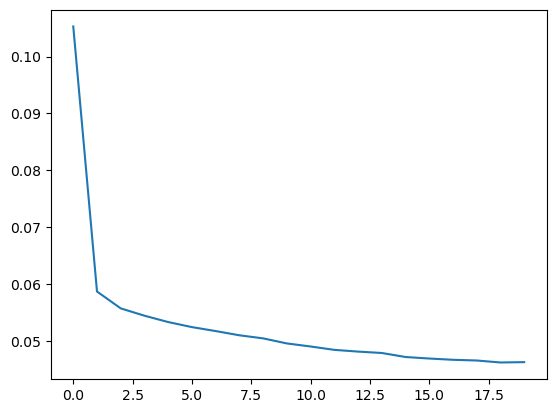

In [14]:
# plot loss
import matplotlib.pyplot as plt
plt.plot(autoencoder.history.history['loss'])



### Reconstructie van originele afbeeldingen

Laten we nu eens kijken wat voor resultaten de `autoencoder` oplevert. Om te beginnen kijken we hoe goed de `decoder` in staat is om afbeeldingen te reconstrueren.

We selecteren willekeurige afbeeldingen uit de testset, coderen deze met de `encoder` en decoderen deze met de `decoder`.

1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 107ms/step
Shape of reconstructed images:  (10, 28, 28, 1)
Type of reconstructed images:  <class 'numpy.ndarray'>
Min and Max values in reconstructed images:  3.2104622e-10 0.9976942


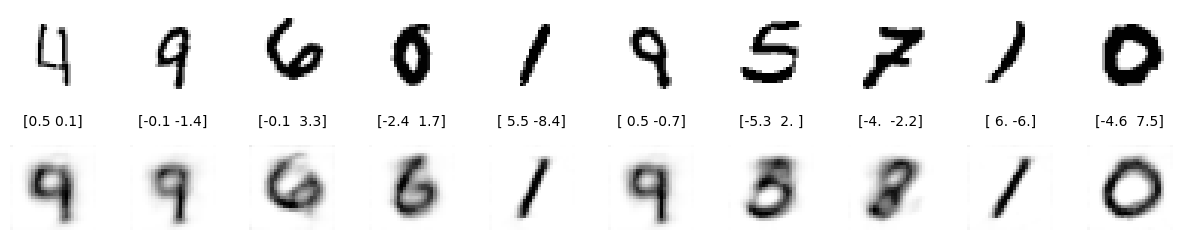

In [15]:
import matplotlib.pyplot as plt

n = 10

# selecteer willekeurige afbeeldingen uit x_test
idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[idx]

# vertaal met de encoder naar getallen
z_points = encoder.predict(test_images)

# vertaal de getallen met de decoder terug naar afbeeldingen
reconstr_images = decoder.predict(z_points)

print("Shape of reconstructed images: ", reconstr_images.shape)
print("Type of reconstructed images: ", type(reconstr_images))

print("Min and Max values in reconstructed images: ", reconstr_images.min(), reconstr_images.max())

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n):
    img = test_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')
    
for i in range(n):
    img = reconstr_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + n + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

Bovenstaande plot laat op de bovenste rij de originele afbeeldingen zien en daaronder telkens de door de decoder gereconstrueerde afbeelding.

Wat valt je op aan de reconstructies?

- Alle gereconstrueerde afbeeldingen zijn een beetje wazig/fuzzy

Om een beter beeld te krijgen van het gedrag van de autoencoder, plotten we de outputs van de encoder (de 'z-waarden') voor een deel van de testset. De kleur van een punt geeft het correcte label weer.

Daarnaast selecteren we alvast een aantal willekeurige punten (dus een combinatie van twee willekeurige getallen) die we dadelijk gaan gebruiken om volledig nieuwe afbeeldingen te genereren. Deze punten worden in het rood weergegeven.

  1/157 [..............................] - ETA: 2s

157/157 [==============================] - 1s 8ms/step


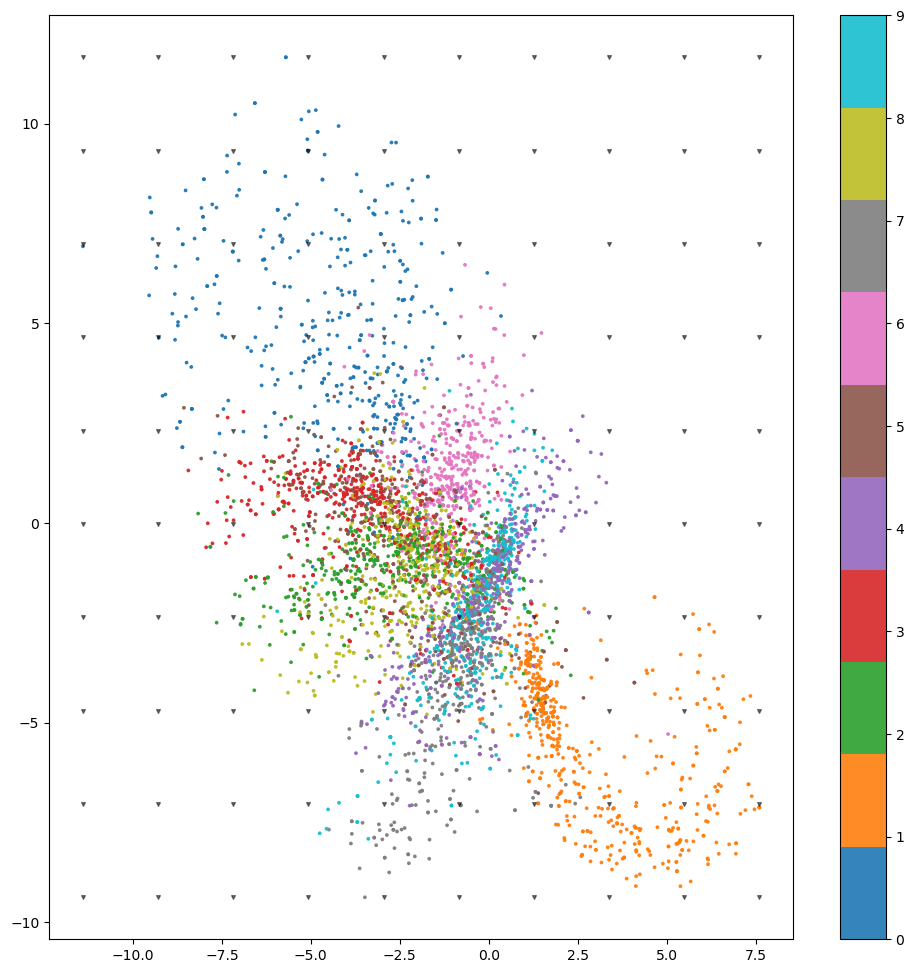

In [16]:
n = 5000
grid_size = 10
grid_depth = 10 
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[example_idx]
test_labels = y_test[example_idx]

z_points = encoder.predict(test_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize = (figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , c=test_labels, cmap='tab10', alpha = 0.9, s = 3)
plt.colorbar()

# willekeurige punten
x_values = np.linspace(min_x,max_x, grid_size)
y_values = np.linspace(min_y,max_y, grid_depth)
z_grid = np.dstack(np.meshgrid(x_values, y_values))

plt.scatter(z_grid[:, :, 0] , z_grid[:, :, 1], c='black', alpha=.5, s=7, marker="v")
plt.show()


Wat valt je op aan bovenstaande plot met betrekking tot de verdeling van de labels?

- Alle labels zijn ongeveer gelijk verdeelt (dezelfde hoeveelheid punten in de graaf). In het midden van de scatterplot bevinden zich de meeste punten, en verspreiden zich naar de andere hoeken van de plot. Er zijn wel een paar patronen te zien, de labels groeperen wel bij elkaar in de plot.

Wat valt je op aan bovenstaande plot met betrekking tot de willekeurig geselecteerde punten?

- Deze willekeurige punten bevinden zich vooral rond het midden van de scatter plot.

We gebruiken nu de `decoder` om op basis van de willekeurig gegenereerde punten volledig nieuwe afbeeldingen te genereren en plotten deze afbeeldingen.

In [17]:
figure = np.zeros((28*grid_depth, 28*grid_size))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y]])
        generated_image = decoder.predict(latent_point, verbose=0)[0]
        # Replace pixels in figure
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28] = generated_image[:,:,-1]

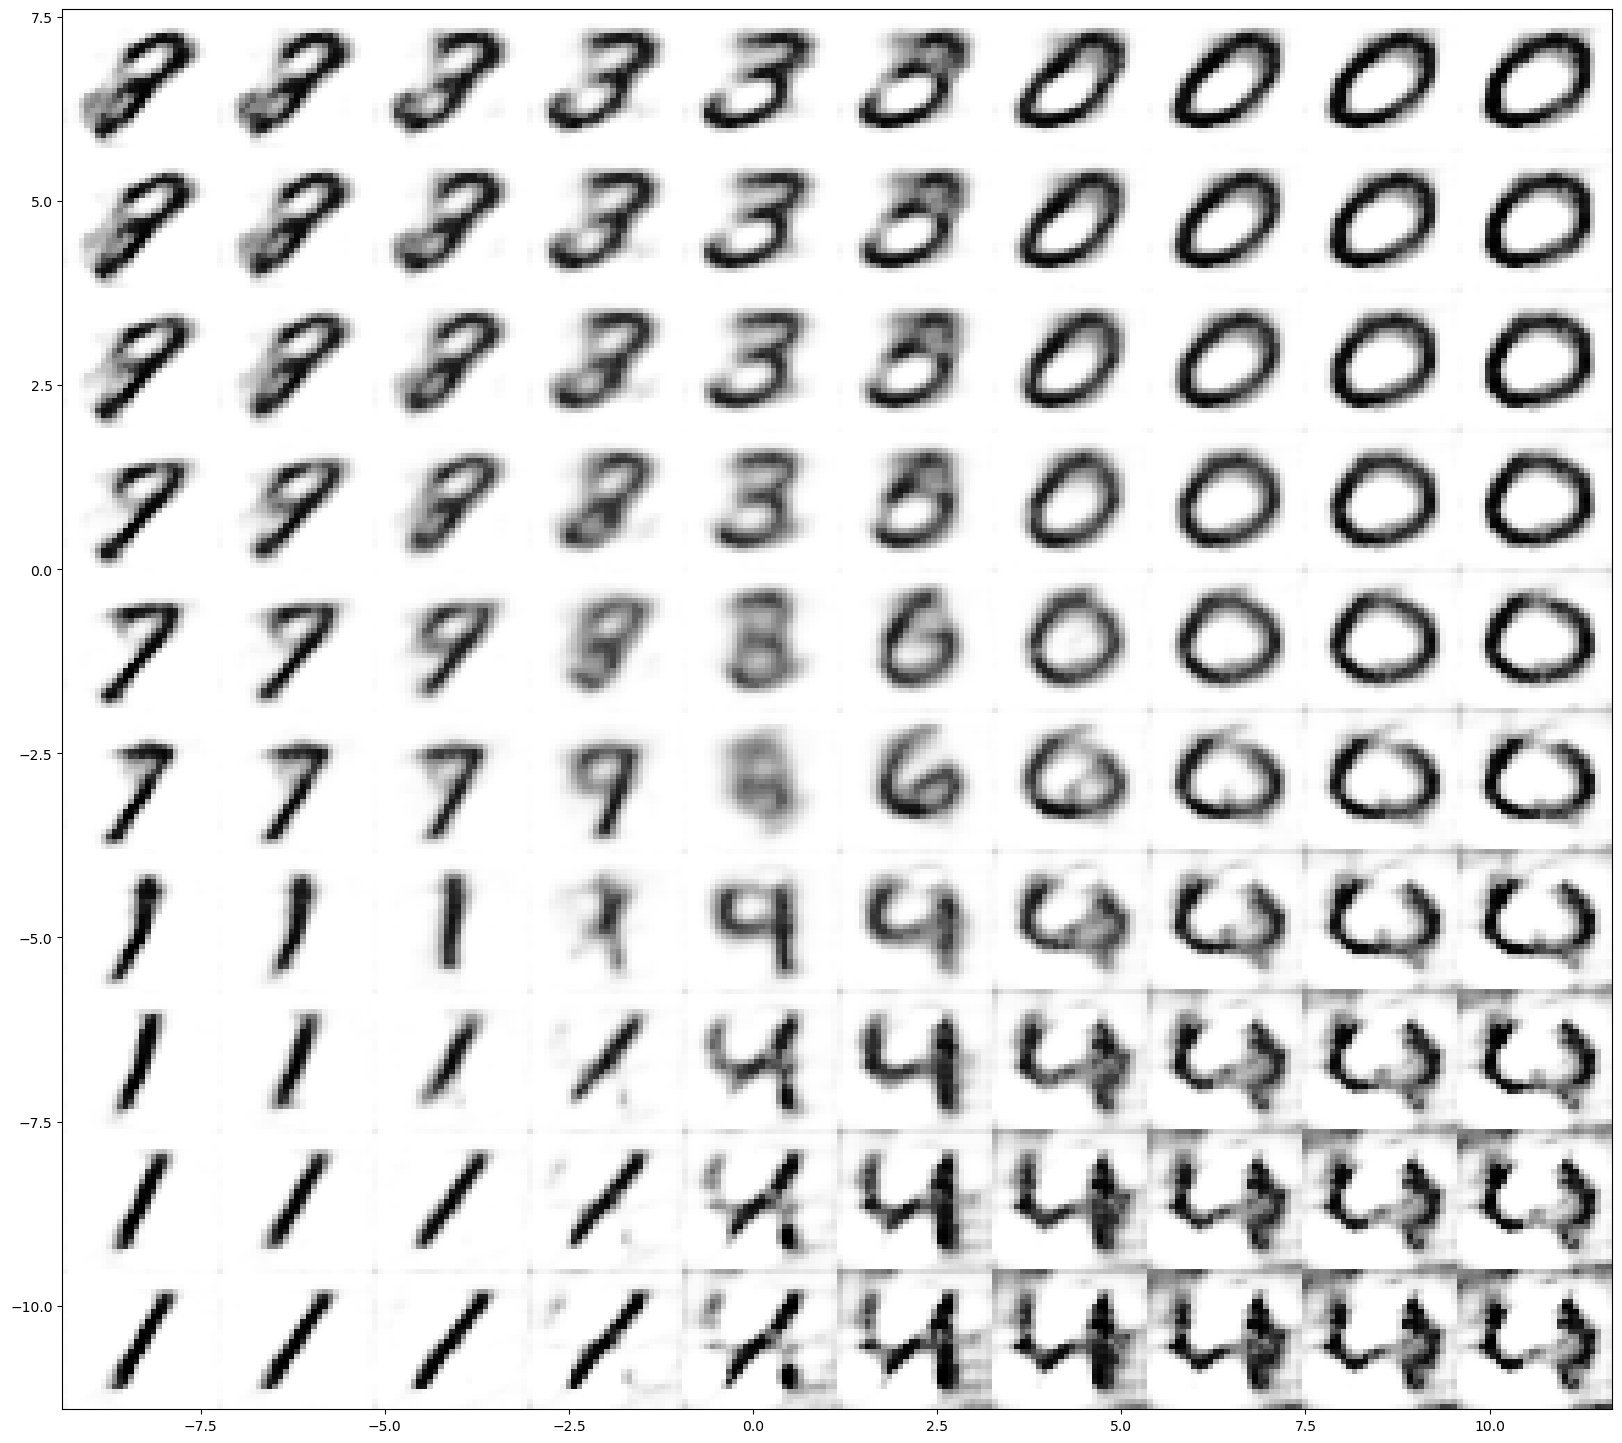

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(figure, cmap="gray_r", extent=[min_y, max_y, min_x, max_x])
plt.show()

Wat valt je op aan deze afbeeldingen?

- De labels/getallen lopen langzaam over op elkaar. Bijvoordbeeld links onder veranderend de 1 in een 7 en 9 als je omhoog gaat. Ook veranderd de 0 in een 3/8 en in een 6. Rechtsonder gebeuren er rare dingen met de 4, wat ik niet kan uitleggen.

Varieer nu eens met het aantal lagen en filters in de `encoder` en `decoder`. Kun je de `decoder` een volledig andere vorm geven dan de `encoder`? Hoe beïnvloed dit het resultaat?